<a href="https://colab.research.google.com/github/madan20maccccc/Seizure-Detection-using-EEG-data-with-ML-models/blob/main/Seizure_Detection_using_EEG_data_with_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Required Libraries***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, silhouette_score
)
from sklearn.metrics import pairwise_distances

from scipy.stats import mode
from imblearn.over_sampling import SMOTE
from matplotlib.colors import ListedColormap


# ***Data Cleaning***

In [ ]:
# Load and clean dataset
data = pd.read_csv('/content/Epileptic Seizure Recognition.csv').drop(columns=['Unnamed'], errors='ignore')

# Handle missing values and duplicates
if data.isnull().any().any():
    print("Missing Values:\n", data.isnull().sum()[data.isnull().sum() > 0])
if data.duplicated().sum() > 0:
    data = data.drop_duplicates()
    print(f"Removed {data.duplicated().sum()} duplicate rows")

# Display dataset info
print(f"Shape: {data.shape}\nData Types:\n{data.dtypes}")
# Save cleaned data
data.to_csv('cleaned_seizure_data.csv', index=False)
print("Saved cleaned data")

Shape: (11500, 179)
Data Types:
X1      int64
X2      int64
X3      int64
X4      int64
X5      int64
        ...  
X175    int64
X176    int64
X177    int64
X178    int64
y       int64
Length: 179, dtype: object
Saved cleaned data


# ***Data Preprocessing***

Using PCA for Preprocessing


In [ ]:
# Create binary target: 1 if seizure, else 0
data['y_binary'] = (data['y'] == 1).astype(int)

# Separate features and target
X = data.drop(['y', 'y_binary'], axis=1)
y = data['y_binary']

# Standardize features and apply PCA (40 components)
X_scaled = StandardScaler().fit_transform(X)
X_pca = PCA(n_components=40, random_state=42).fit_transform(X_scaled)
print(f"Shape after PCA: {X_pca.shape}")

# Combine PCA features with targets
reduced_data = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
reduced_data[['y', 'y_binary']] = data[['y', 'y_binary']].reset_index(drop=True)
print(f"Reduced dataset shape: {reduced_data.shape}")

# Save reduced dataset
reduced_data.to_csv('reduced_seizure_data_pca.csv', index=False)
print("Saved PCA reduced dataset")

Shape after PCA: (11500, 40)
Reduced dataset shape: (11500, 42)
Saved PCA reduced dataset


# ***Splitting For Model Making***

In [ ]:
# Set seed and load PCA-reduced dataset
np.random.seed(42)
data = pd.read_csv('reduced_seizure_data_pca.csv')

# Ensure binary target
data['y_binary'] = (data['y'] == 1).astype(int)

# Features and target
X = data.drop(['y', 'y_binary'], axis=1)
y = data['y_binary']

# Stratified train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save splits
X_train.to_csv('X_train_pca.csv', index=False)
X_test.to_csv('X_test_pca.csv', index=False)
y_train.to_csv('y_train_pca.csv', index=False)
y_test.to_csv('y_test_pca.csv', index=False)

# Summary
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")
print("Saved train/test splits")

Train size: (9200, 40), Test size: (2300, 40)
Saved train/test splits


# ***Exploratory Data Analysis***

In [ ]:
# Load PCA-reduced dataset
data = pd.read_csv('reduced_seizure_data_pca.csv')

# Display info and stats
print("Dataset Info:\n", data.info())
print("Stats:\n", data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Data columns (total 42 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PC1       11500 non-null  float64
 1   PC2       11500 non-null  float64
 2   PC3       11500 non-null  float64
 3   PC4       11500 non-null  float64
 4   PC5       11500 non-null  float64
 5   PC6       11500 non-null  float64
 6   PC7       11500 non-null  float64
 7   PC8       11500 non-null  float64
 8   PC9       11500 non-null  float64
 9   PC10      11500 non-null  float64
 10  PC11      11500 non-null  float64
 11  PC12      11500 non-null  float64
 12  PC13      11500 non-null  float64
 13  PC14      11500 non-null  float64
 14  PC15      11500 non-null  float64
 15  PC16      11500 non-null  float64
 16  PC17      11500 non-null  float64
 17  PC18      11500 non-null  float64
 18  PC19      11500 non-null  float64
 19  PC20      11500 non-null  float64
 20  PC21      11500 non-null  fl

Seizure vs Non-Seizure

In [ ]:
# Display and plot binary class distribution
print("Class Distribution:\n", data['y_binary'].value_counts())
sns.countplot(x='y_binary', data=data).set(title='Seizure (1) vs Non-Seizure (0)', xlabel='Class', ylabel='Count')
plt.show()


NameError: name 'data' is not defined

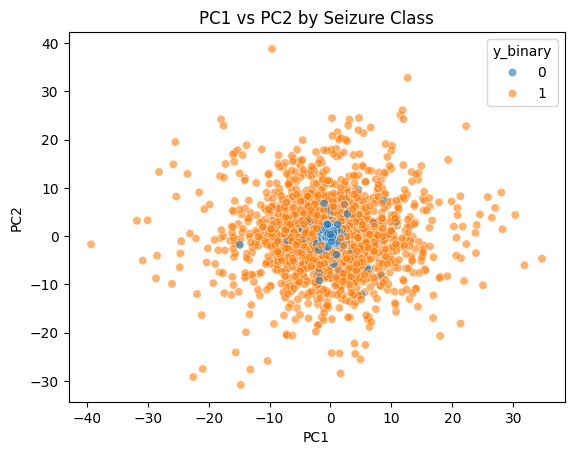

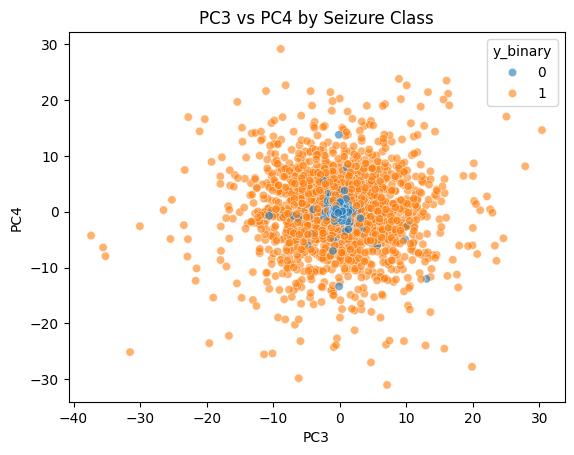

Class Distribution:
 y_binary
0    9200
1    2300
Name: count, dtype: int64


In [ ]:
# Load PCA-reduced dataset
data = pd.read_csv('reduced_seizure_data_pca.csv')

# Scatter plots: PC1 vs PC2 and PC3 vs PC4
for pc_x, pc_y in [('PC1', 'PC2'), ('PC3', 'PC4')]:
    sns.scatterplot(x=pc_x, y=pc_y, hue='y_binary', data=data, alpha=0.6).set(
        title=f'{pc_x} vs {pc_y} by Seizure Class', xlabel=pc_x, ylabel=pc_y)
    plt.show()

# Display class distribution
print("Class Distribution:\n", data['y_binary'].value_counts())

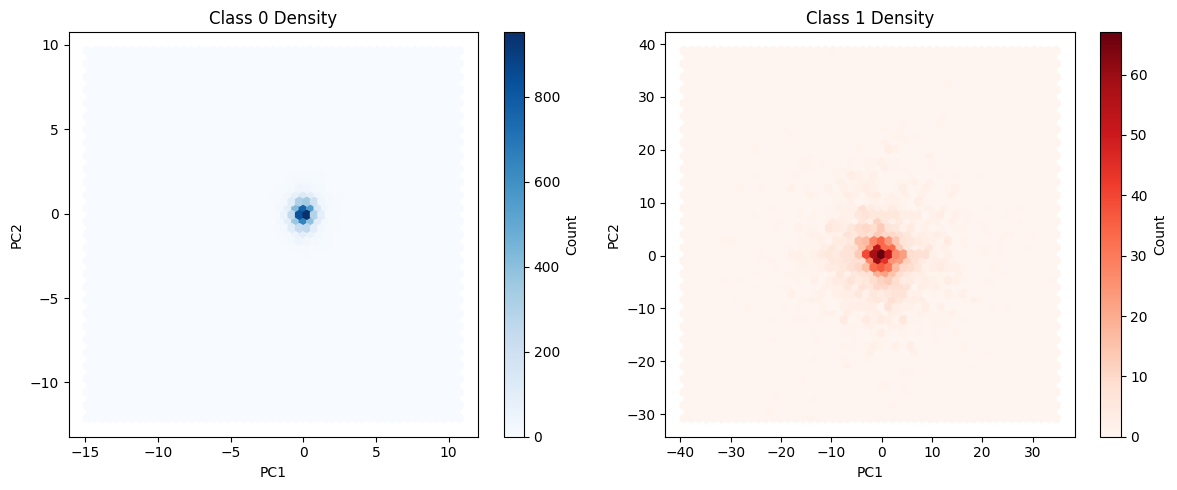

In [ ]:
# Hexbin density plots for PC1 vs PC2 by class
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Class 0 density
ax1.hexbin(data.loc[data['y_binary'] == 0, 'PC1'], data.loc[data['y_binary'] == 0, 'PC2'],
           gridsize=50, cmap='Blues')
ax1.set(title='Class 0 Density', xlabel='PC1', ylabel='PC2')
fig.colorbar(ax1.collections[0], ax=ax1, label='Count')

# Class 1 density
ax2.hexbin(data.loc[data['y_binary'] == 1, 'PC1'], data.loc[data['y_binary'] == 1, 'PC2'],
           gridsize=50, cmap='Reds')
ax2.set(title='Class 1 Density', xlabel='PC1', ylabel='PC2')
fig.colorbar(ax2.collections[0], ax=ax2, label='Count')

plt.tight_layout()
plt.show()

Correlation Matrix


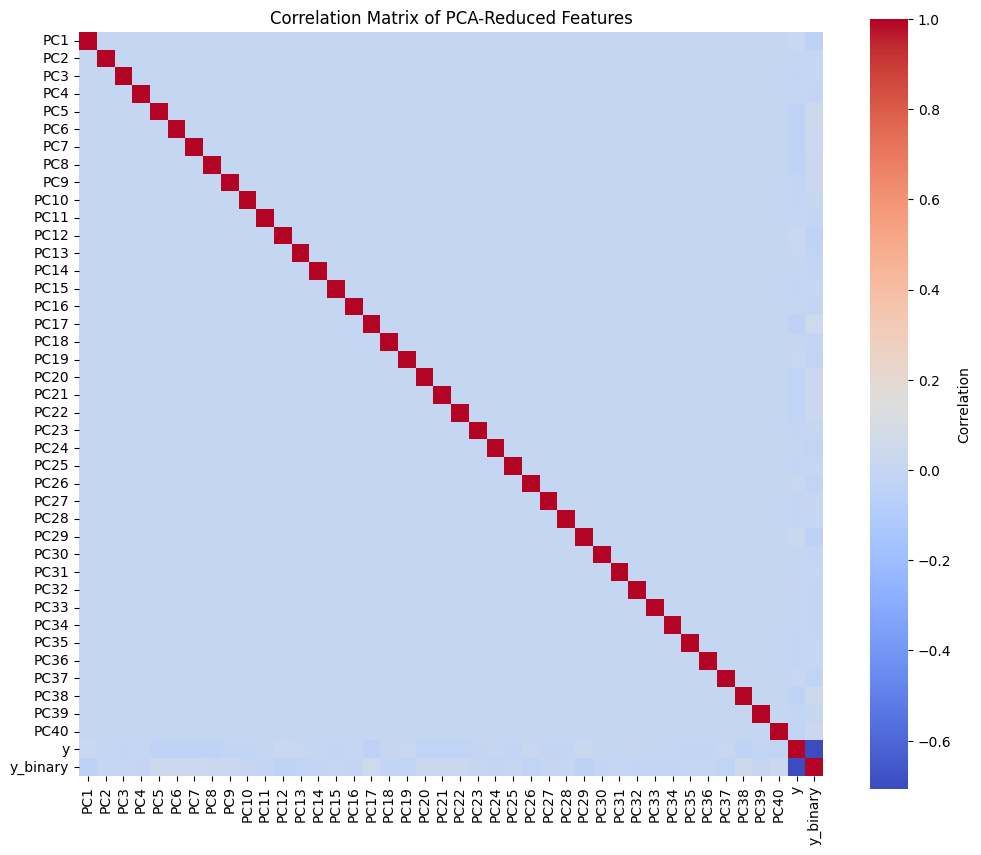

In [ ]:
# Correlation matrix of PCA-reduced features
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), cmap='coolwarm', square=True, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix of PCA-Reduced Features")
plt.show()


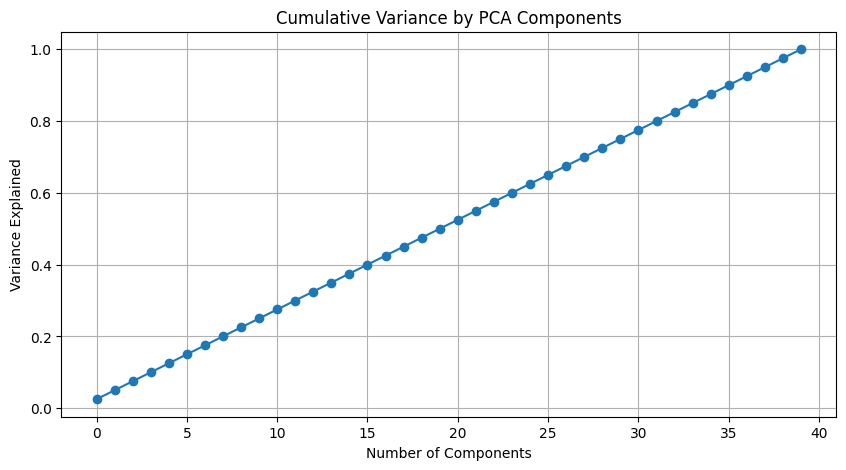

In [ ]:
# Extract PCA features and standardize
X = data.drop(['y', 'y_binary'], axis=1)
X_scaled = StandardScaler().fit_transform(X)

# Fit PCA and plot cumulative explained variance
pca = PCA(n_components=40).fit(X_scaled)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.grid(True)
plt.gca().set(title='Cumulative Variance by PCA Components', xlabel='Number of Components', ylabel='Variance Explained')
plt.show()

Boxplot

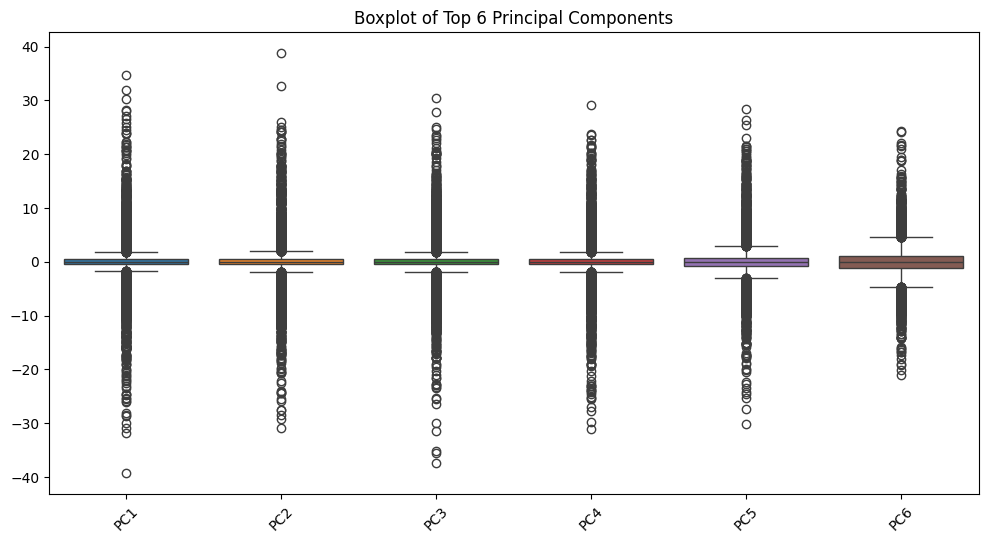

In [ ]:
top_pcs = [f'PC{i}' for i in range(1, 7)]
plt.figure(figsize=(12, 6))
sns.boxplot(data=data[top_pcs])
plt.title('Boxplot of Top 6 Principal Components')
plt.xticks(rotation=45)
plt.show()

# ***SUPERVISED MODEL***

In [ ]:
# Load already PCA-reduced train-test sets
X_train = pd.read_csv('X_train_pca.csv')
X_test = pd.read_csv('X_test_pca.csv')
y_train = pd.read_csv('y_train_pca.csv').squeeze()
y_test = pd.read_csv('y_test_pca.csv').squeeze()

# Models dictionary
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42)
}

print("=== MODEL PERFORMANCE ===")

for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_train)
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    train_roc_auc = roc_auc_score(y_train, y_train_proba)
    test_roc_auc = roc_auc_score(y_test, y_test_proba)

    if train_f1 > 0.85 and abs(train_f1 - test_f1) < 0.05:
        fit_status = "Good Fit"
    elif train_f1 > 0.85 and test_f1 < 0.70:
        fit_status = "Overfitting"
    elif train_f1 < 0.70 and test_f1 < 0.70:
        fit_status = "Underfitting"
    else:
        fit_status = "Borderline / Needs tuning"

    print(f"\n--- {name} ---")
    print(f"Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f} | Train ROC-AUC: {train_roc_auc:.4f}")
    print(f"Test  Acc: {test_acc:.4f} | Test  F1: {test_f1:.4f} | Test  ROC-AUC: {test_roc_auc:.4f}")
    print(f"Fit Status: {fit_status}")

    print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
    print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


=== MODEL PERFORMANCE ===

--- Logistic Regression ---
Train Acc: 0.8116 | Train F1: 0.1117 | Train ROC-AUC: 0.5691
Test  Acc: 0.8065 | Test  F1: 0.0632 | Test  ROC-AUC: 0.5100
Fit Status: Underfitting
Test Confusion Matrix:
 [[1840    0]
 [ 445   15]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.89      1840
           1       1.00      0.03      0.06       460

    accuracy                           0.81      2300
   macro avg       0.90      0.52      0.48      2300
weighted avg       0.84      0.81      0.73      2300


--- Decision Tree ---
Train Acc: 1.0000 | Train F1: 1.0000 | Train ROC-AUC: 1.0000
Test  Acc: 0.9548 | Test  F1: 0.8870 | Test  ROC-AUC: 0.9293
Fit Status: Borderline / Needs tuning
Test Confusion Matrix:
 [[1788   52]
 [  52  408]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1840
           1       

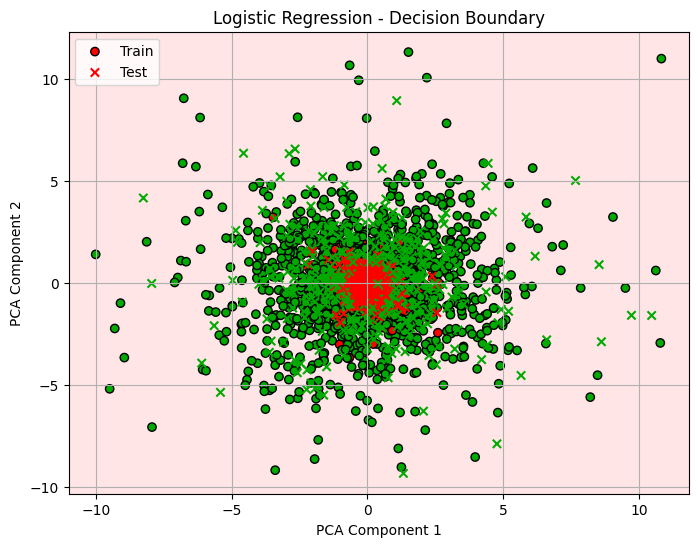

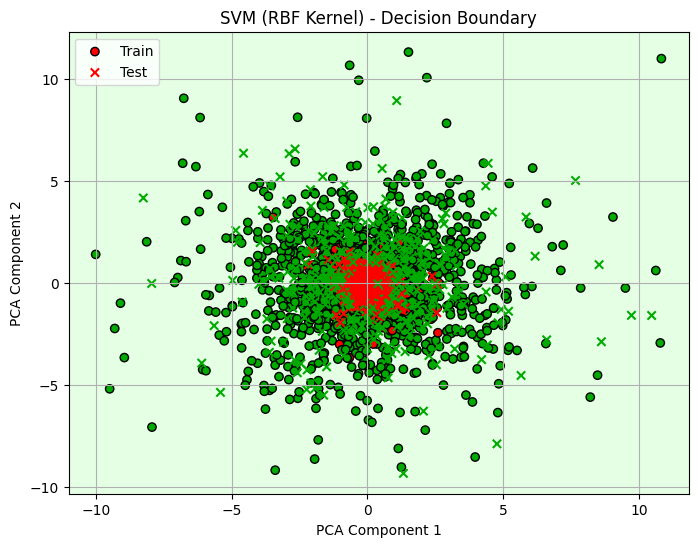

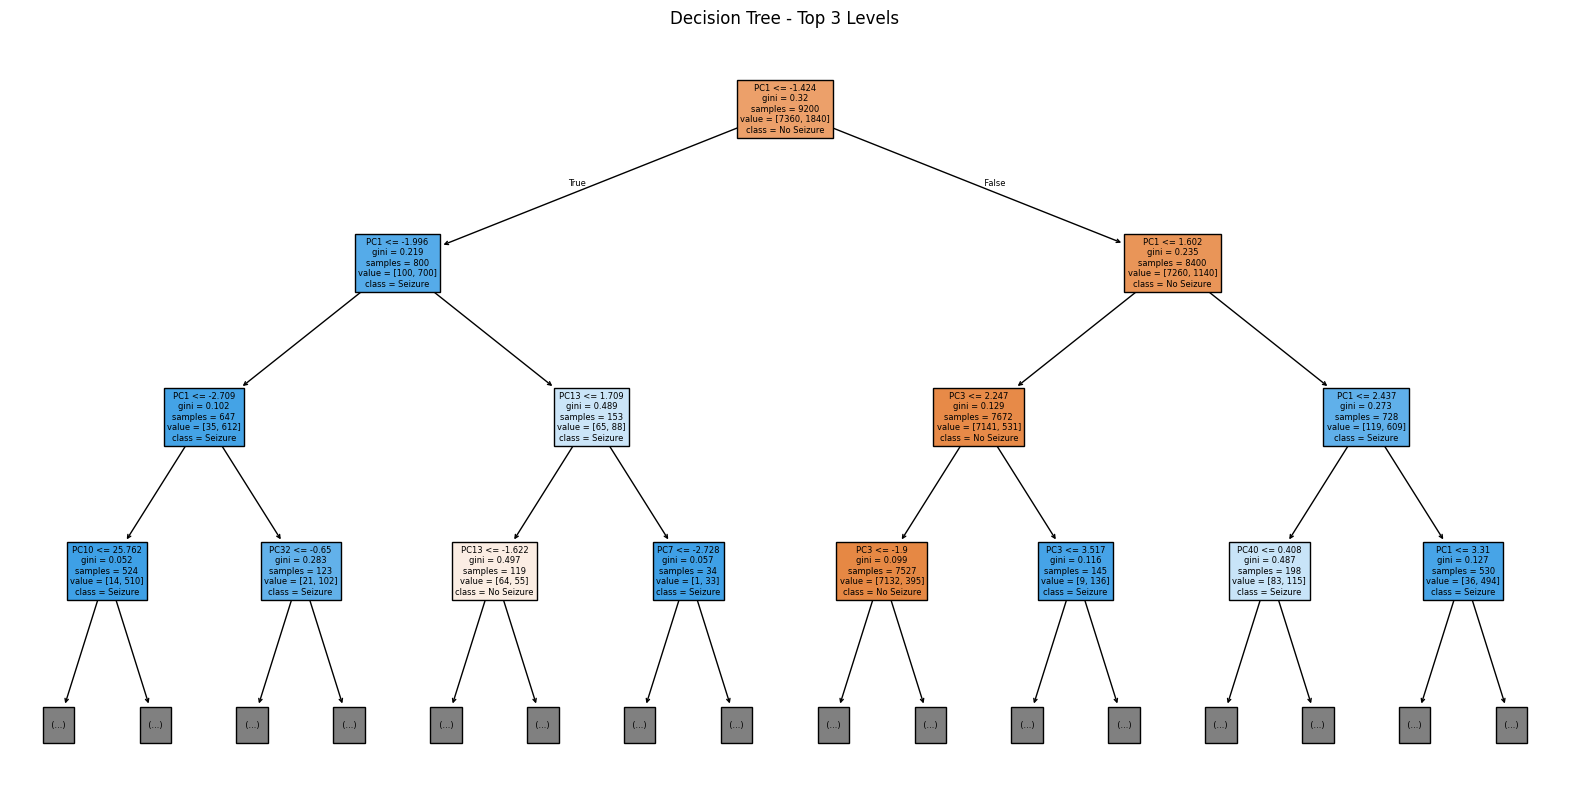

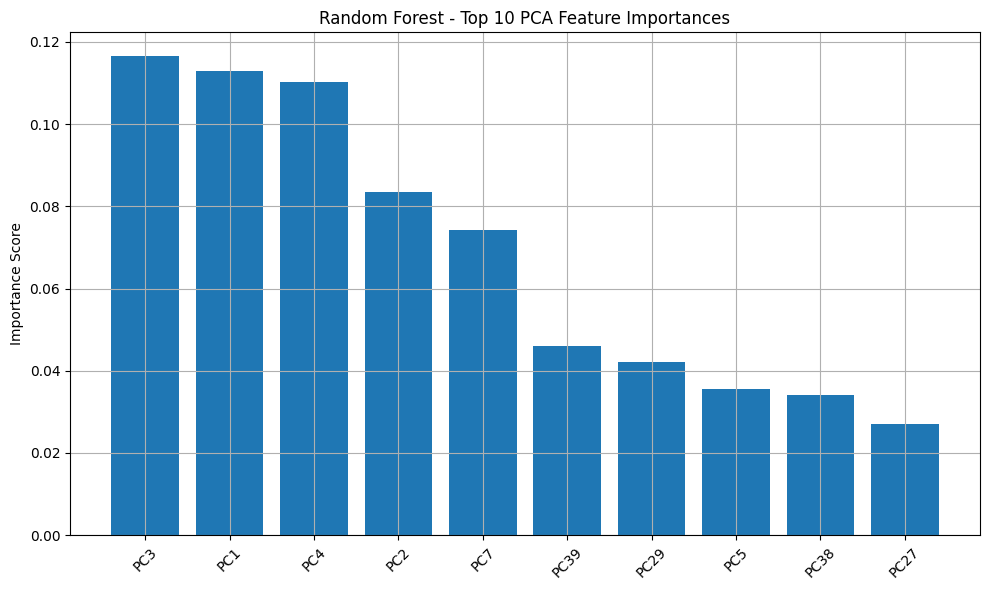

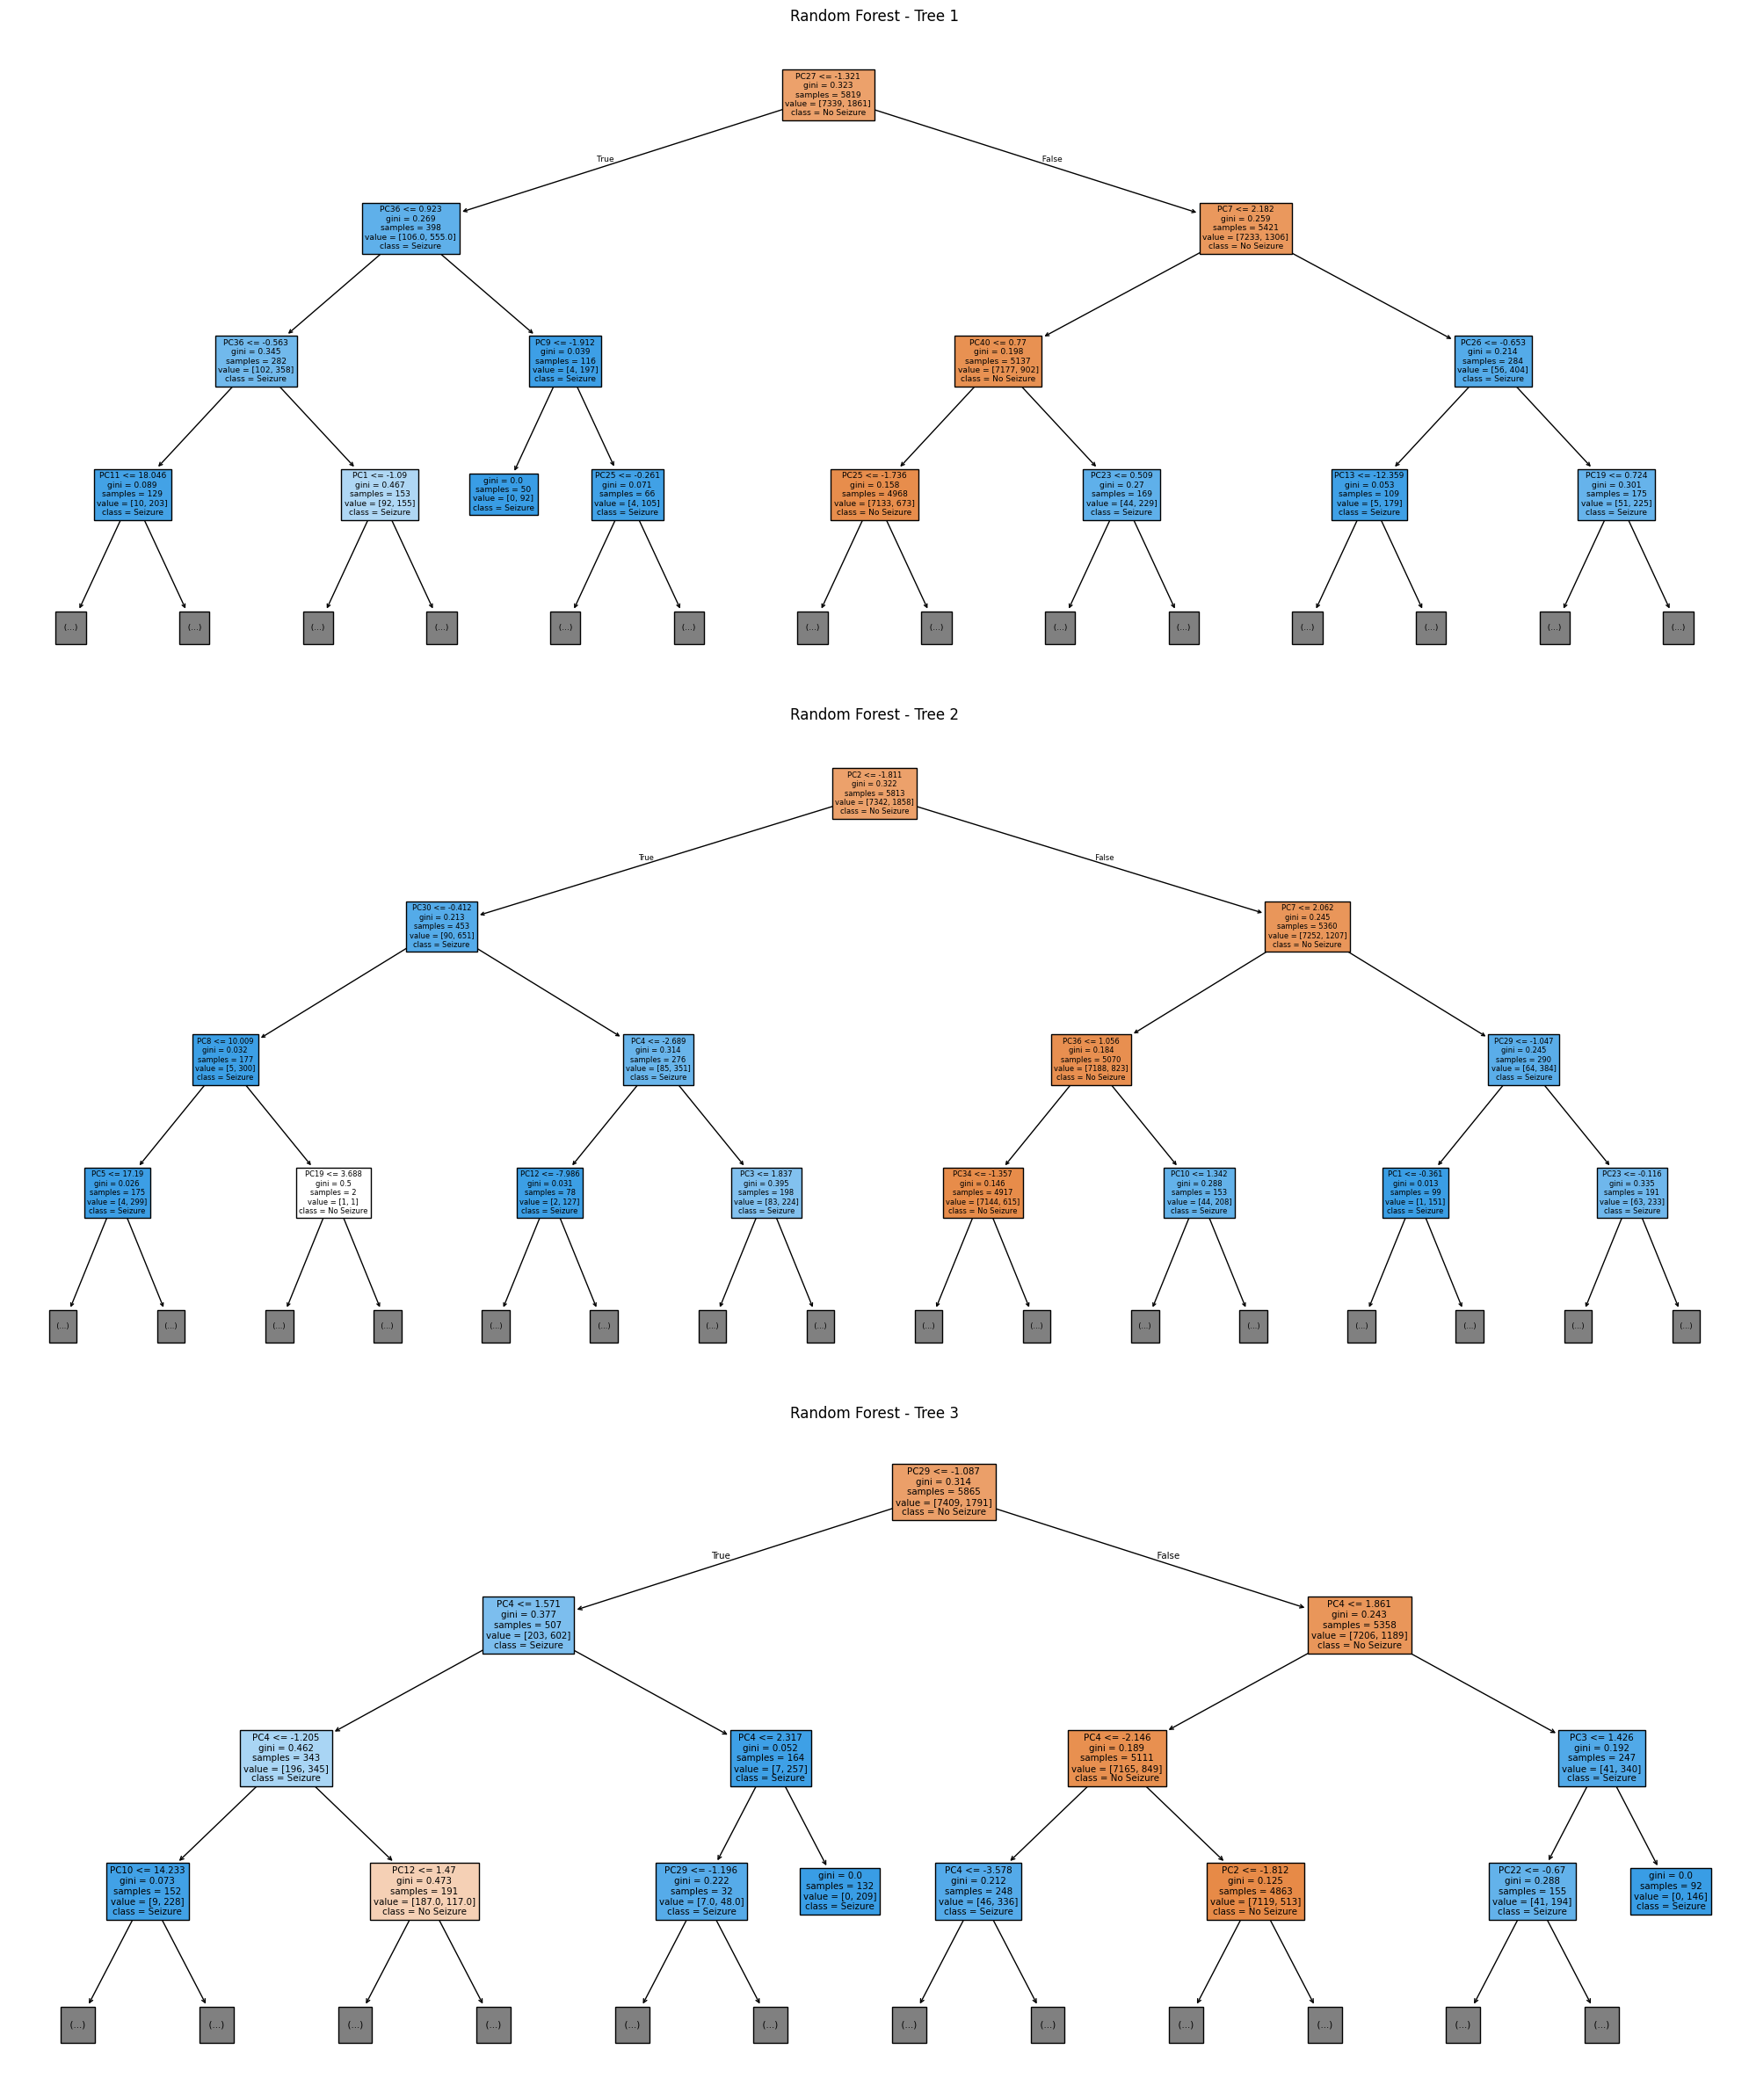

In [ ]:
# Load PCA-reduced data
data = pd.read_csv('reduced_seizure_data_pca.csv')
X_40 = data.drop(columns=['y', 'y_binary'])
y = data['y_binary']

# Reduce to 2 components for visualization only
scaler = StandardScaler()
X_2d = PCA(n_components=2, random_state=42).fit_transform(scaler.fit_transform(X_40))
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(X_2d, y, test_size=0.2, random_state=42, stratify=y)

# Meshgrid setup
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

# Colormaps
cmap_light = ListedColormap(['#FFCCCC', '#CCFFCC'])
cmap_bold = ListedColormap(['#FF0000', '#00AA00'])

def plot_decision_boundary(clf, X_train, y_train, X_test, y_test, title):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.5)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', label='Train')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='x', label='Test')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Logistic Regression Decision Boundary
clf_lr = LogisticRegression(max_iter=1000, random_state=42)
clf_lr.fit(X_train_2d, y_train_2d)
plot_decision_boundary(clf_lr, X_train_2d, y_train_2d, X_test_2d, y_test_2d, "Logistic Regression - Decision Boundary")

# SVM Decision Boundary
clf_svm = SVC(kernel='rbf', probability=True, random_state=42)
clf_svm.fit(X_train_2d, y_train_2d)
plot_decision_boundary(clf_svm, X_train_2d, y_train_2d, X_test_2d, y_test_2d, "SVM (RBF Kernel) - Decision Boundary")

# === Tree Visualization using PCA components ===
X_train_40 = pd.read_csv('X_train_pca.csv')
y_train_40 = pd.read_csv('y_train_pca.csv').squeeze()

clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train_40, y_train_40)
plt.figure(figsize=(20, 10))
plot_tree(clf_tree, max_depth=3, filled=True,
          feature_names=[f'PC{i+1}' for i in range(X_train_40.shape[1])],
          class_names=['No Seizure', 'Seizure'])
plt.title("Decision Tree - Top 3 Levels")
plt.show()

# === Random Forest Feature Importances ===
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_40, y_train_40)
importances = clf_rf.feature_importances_
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 6))
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [f'PC{i+1}' for i in indices], rotation=45)
plt.title("Random Forest - Top 10 PCA Feature Importances")
plt.ylabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Random Forest - Visualize Few Trees (Forest-Like View) ===
n_trees_to_show = 3
plt.figure(figsize=(20, 8 * n_trees_to_show))

for i in range(n_trees_to_show):
    plt.subplot(n_trees_to_show, 1, i + 1)
    plot_tree(clf_rf.estimators_[i],
              max_depth=3, filled=True,
              feature_names=[f'PC{i+1}' for i in range(X_train_40.shape[1])],
              class_names=['No Seizure', 'Seizure'])
    plt.title(f"Random Forest - Tree {i+1}")

plt.tight_layout()
plt.show()


In [ ]:

# Load data
data = pd.read_csv('cleaned_seizure_data.csv')
data['y_binary'] = (data['y'] == 1).astype(int)
X = data.drop(columns=['y', 'y_binary'])
y = data['y_binary']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print(f"Before SMOTE: Train class distribution:\n{y_train.value_counts()}")
print(f"After SMOTE: Train class distribution:\n{pd.Series(y_train_sm).value_counts()}")

# Define Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=15,
    cv=4,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit on SMOTE data
random_search.fit(X_train_sm, y_train_sm)

print("Best Hyperparameters found:", random_search.best_params_)

# Best model
best_rf = random_search.best_estimator_

# Predictions on train (SMOTE) and test (original)
y_train_pred = best_rf.predict(X_train_sm)
y_test_pred = best_rf.predict(X_test)

# Calculate metrics
train_acc = accuracy_score(y_train_sm, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
train_f1 = f1_score(y_train_sm, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

print("\n=== Performance after tuning with SMOTE ===")
print(f"Train Accuracy: {train_acc:.4f} | Train F1: {train_f1:.4f}")
print(f"Test  Accuracy: {test_acc:.4f} | Test  F1: {test_f1:.4f}")

# Fit quality check
if train_f1 > 0.85 and abs(train_f1 - test_f1) < 0.05:
    fit_status = "Good Fit"
elif train_f1 > 0.85 and test_f1 < 0.70:
    fit_status = "Overfitting"
elif train_f1 < 0.70 and test_f1 < 0.70:
    fit_status = "Underfitting"
else:
    fit_status = "Borderline / Needs tuning"

print(f"Fit Status: {fit_status}\n")

# Confusion matrix and classification report on test set
print("Test Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Before SMOTE: Train class distribution:
y_binary
0    7360
1    1840
Name: count, dtype: int64
After SMOTE: Train class distribution:
y_binary
0    7360
1    7360
Name: count, dtype: int64
Fitting 4 folds for each of 15 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_p

Best Hyperparameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}

=== Performance after tuning with SMOTE ===
Train Accuracy: 1.0000 | Train F1: 1.0000
Test  Accuracy: 0.9757 | Test  F1: 0.9412
Fit Status: Borderline / Needs tuning

Test Confusion Matrix:
 [[1796   44]
 [  12  448]]
Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1840
           1       0.91      0.97      0.94       460

    accuracy                           0.98      2300
   macro avg       0.95      0.98      0.96      2300
weighted avg       0.98      0.98      0.98      2300



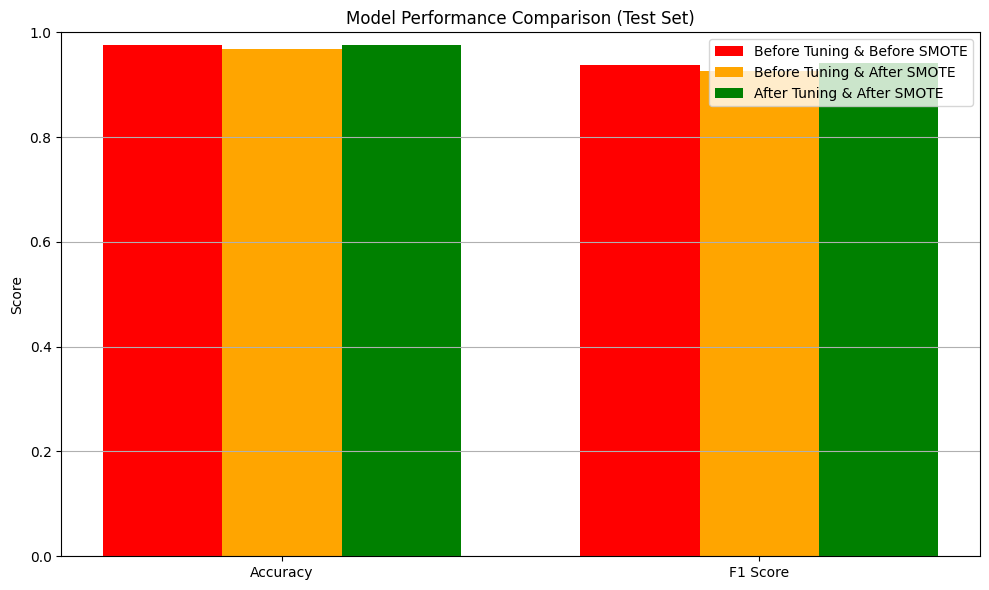

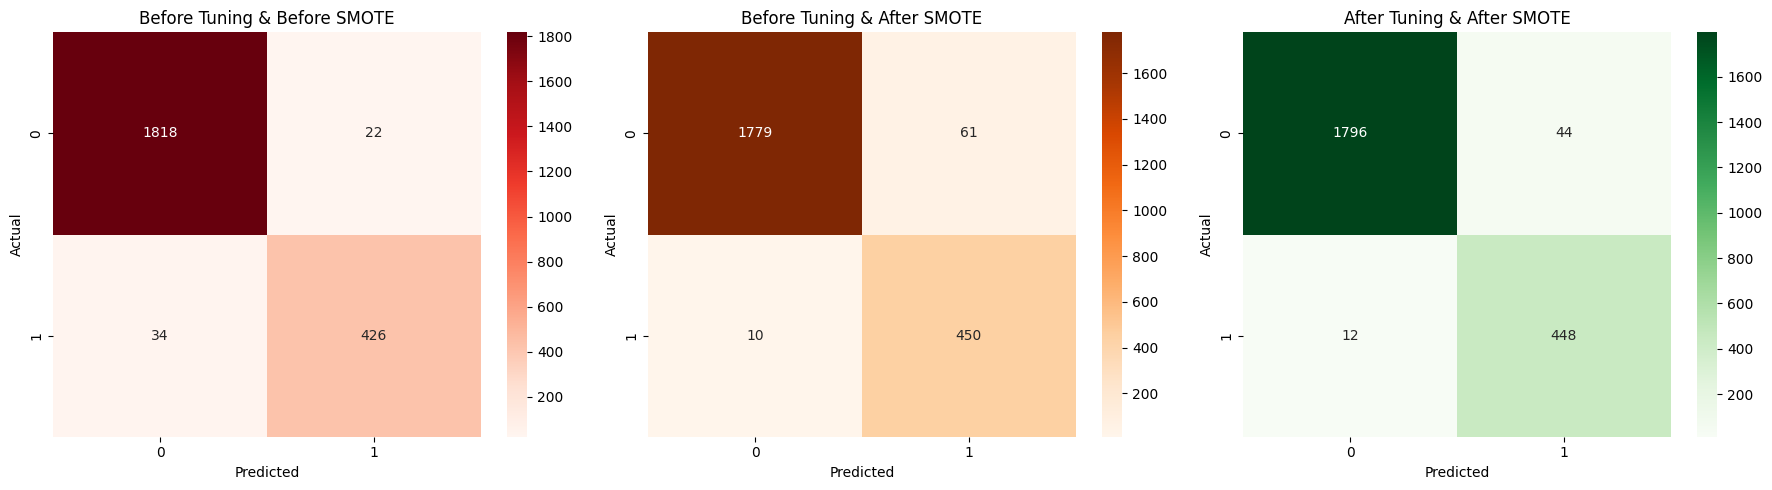

=== Classification Report - Before Tuning & Before SMOTE ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1840
           1       0.95      0.93      0.94       460

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.96      2300
weighted avg       0.98      0.98      0.98      2300

=== Classification Report - Before Tuning & After SMOTE ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1840
           1       0.88      0.98      0.93       460

    accuracy                           0.97      2300
   macro avg       0.94      0.97      0.95      2300
weighted avg       0.97      0.97      0.97      2300

=== Classification Report - After Tuning & After SMOTE ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1840
           1       0.91      0.97      0.94       460

  

In [ ]:


# Assuming 'data' is your dataframe, 'X' and 'y' defined as usual
# y_binary is your binary target column

# 1. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 3. SMOTE on training set only
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# === Model 1: Before tuning & BEFORE SMOTE ===
model_before = RandomForestClassifier(random_state=42)
model_before.fit(X_train, y_train)
y_pred_before = model_before.predict(X_test)
acc_before = accuracy_score(y_test, y_pred_before)
f1_before = f1_score(y_test, y_pred_before)

# === Model 2: Before tuning & AFTER SMOTE ===
model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_train_sm, y_train_sm)
y_pred_smote = model_smote.predict(X_test)
acc_smote = accuracy_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)

# === Model 3: After tuning & AFTER SMOTE ===
# 'best_rf' assumed to be your tuned model, already trained on (X_train_sm, y_train_sm)
y_pred_tuned = best_rf.predict(X_test)
acc_tuned = accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)

# === Plot comparison of Accuracy and F1 Score ===
metrics = ['Accuracy', 'F1 Score']
before_scores = [acc_before, f1_before]
smote_scores = [acc_smote, f1_smote]
tuned_scores = [acc_tuned, f1_tuned]

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, before_scores, width, label='Before Tuning & Before SMOTE', color='red')
plt.bar(x, smote_scores, width, label='Before Tuning & After SMOTE', color='orange')
plt.bar(x + width, tuned_scores, width, label='After Tuning & After SMOTE', color='green')

plt.ylabel('Score')
plt.title('Model Performance Comparison (Test Set)')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# === Confusion Matrices ===
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_before), annot=True, fmt='d', ax=axes[0], cmap="Reds")
axes[0].set_title("Before Tuning & Before SMOTE")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_smote), annot=True, fmt='d', ax=axes[1], cmap="Oranges")
axes[1].set_title("Before Tuning & After SMOTE")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='d', ax=axes[2], cmap="Greens")
axes[2].set_title("After Tuning & After SMOTE")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# === Classification Reports ===
print("=== Classification Report - Before Tuning & Before SMOTE ===")
print(classification_report(y_test, y_pred_before))

print("=== Classification Report - Before Tuning & After SMOTE ===")
print(classification_report(y_test, y_pred_smote))

print("=== Classification Report - After Tuning & After SMOTE ===")
print(classification_report(y_test, y_pred_tuned))


# ***UNSUPERVISED MODEL***

In [ ]:

# Load and preprocess data
data = pd.read_csv('cleaned_seizure_data.csv')
data['y_binary'] = (data['y'] == 1).astype(int)
X = data.drop(columns=['y', 'y_binary'])
y = data['y_binary']

# Standardize and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=40, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)

# Helper function to map clusters to labels (external evaluation)
def map_clusters_to_labels(cluster_labels, true_labels):
    mapped = np.zeros_like(cluster_labels)
    for cluster in np.unique(cluster_labels):
        mask = cluster_labels == cluster
        mapped[mask] = mode(true_labels[mask], keepdims=True)[0]
    return mapped

# Define unsupervised models
models = {
    "KMeans": KMeans(n_clusters=2, random_state=42),
    "GMM": GaussianMixture(n_components=2, random_state=42),
    "Agglomerative": AgglomerativeClustering(n_clusters=2),
    "DBSCAN": DBSCAN(eps=3, min_samples=5)
}

# Evaluate models
fit_results = {}

for name, model in models.items():
    # Fit and predict clusters
    train_clusters = model.fit_predict(X_train) if name != "GMM" else model.fit(X_train).predict(X_train)
    test_clusters = model.fit_predict(X_test) if name != "GMM" else model.predict(X_test)

    # Silhouette scores
    sil_train = silhouette_score(X_train, train_clusters) if len(np.unique(train_clusters)) > 1 else -1
    sil_test = silhouette_score(X_test, test_clusters) if len(np.unique(test_clusters)) > 1 else -1

    # Map cluster labels to true labels for evaluation
    train_labels = map_clusters_to_labels(train_clusters, y_train.values)
    test_labels = map_clusters_to_labels(test_clusters, y_test.values)

    # F1 scores
    f1_train = f1_score(y_train, train_labels)
    f1_test = f1_score(y_test, test_labels)

    # Fit classification based on silhouette scores
    if sil_train >= 0.5 and sil_test >= 0.5 and abs(sil_train - sil_test) < 0.1:
        fit_status = "Good Fit"
    elif sil_train >= 0.5 and sil_test < 0.3:
        fit_status = "Overfitting"
    elif sil_train < 0.3 and sil_test < 0.3:
        fit_status = "Underfitting"
    else:
        fit_status = "Borderline"

    fit_results[name] = {
        'silhouette_train': sil_train,
        'silhouette_test': sil_test,
        'f1_train': f1_train,
        'f1_test': f1_test,
        'fit_status': fit_status,
        'train_labels': train_labels,
        'test_labels': test_labels
    }

    # Print summary
    print(f"\n--- {name} ---")
    print(f"Silhouette Train: {sil_train:.4f} | Test: {sil_test:.4f} => {fit_status}")
    print(f"(Diagnostics) F1 Train: {f1_train:.4f} | F1 Test: {f1_test:.4f}\n")

    # Confusion matrices
    print("Confusion Matrix (Train):")
    print(confusion_matrix(y_train, train_labels))
    print("Classification Report (Train):")
    print(classification_report(y_train, train_labels))

    print("Confusion Matrix (Test):")
    print(confusion_matrix(y_test, test_labels))
    print("Classification Report (Test):")
    print(classification_report(y_test, test_labels))

# Final ranking summary
print("\n\n=== Final Model Summary ===")
for name, res in fit_results.items():
    print(f"{name}: Train Sil = {res['silhouette_train']:.3f}, Test Sil = {res['silhouette_test']:.3f}, Status = {res['fit_status']}")



--- KMeans ---
Silhouette Train: 0.0742 | Test: 0.6312 => Borderline
(Diagnostics) F1 Train: 0.0000 | F1 Test: 0.3470

Confusion Matrix (Train):
[[7360    0]
 [1840    0]]
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7360
           1       0.00      0.00      0.00      1840

    accuracy                           0.80      9200
   macro avg       0.40      0.50      0.44      9200
weighted avg       0.64      0.80      0.71      9200

Confusion Matrix (Test):
[[1838    2]
 [ 363   97]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      1840
           1       0.98      0.21      0.35       460

    accuracy                           0.84      2300
   macro avg       0.91      0.60      0.63      2300
weighted avg       0.86      0.84      0.80      2300



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- GMM ---
Silhouette Train: 0.4852 | Test: 0.4782 => Borderline
(Diagnostics) F1 Train: 0.9052 | F1 Test: 0.8956

Confusion Matrix (Train):
[[7053  307]
 [  65 1775]]
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      7360
           1       0.85      0.96      0.91      1840

    accuracy                           0.96      9200
   macro avg       0.92      0.96      0.94      9200
weighted avg       0.96      0.96      0.96      9200

Confusion Matrix (Test):
[[1750   90]
 [  14  446]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1840
           1       0.83      0.97      0.90       460

    accuracy                           0.95      2300
   macro avg       0.91      0.96      0.93      2300
weighted avg       0.96      0.95      0.96      2300


--- Agglomerative ---
Silhouette Train: 0.0736 | Test: 0.5568 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- DBSCAN ---
Silhouette Train: 0.0505 | Test: -0.0189 => Underfitting
(Diagnostics) F1 Train: 0.0000 | F1 Test: 0.0000

Confusion Matrix (Train):
[[7360    0]
 [1840    0]]
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7360
           1       0.00      0.00      0.00      1840

    accuracy                           0.80      9200
   macro avg       0.40      0.50      0.44      9200
weighted avg       0.64      0.80      0.71      9200

Confusion Matrix (Test):
[[1840    0]
 [ 460    0]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1840
           1       0.00      0.00      0.00       460

    accuracy                           0.80      2300
   macro avg       0.40      0.50      0.44      2300
weighted avg       0.64      0.80      0.71      2300



=== Final Model Summary ===
KMeans: Train Sil = 0.074, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

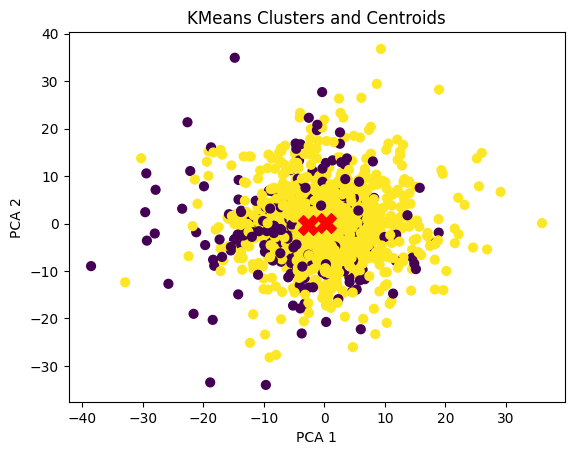

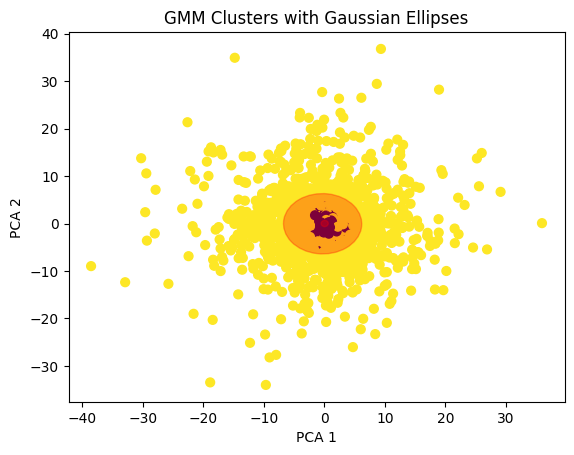

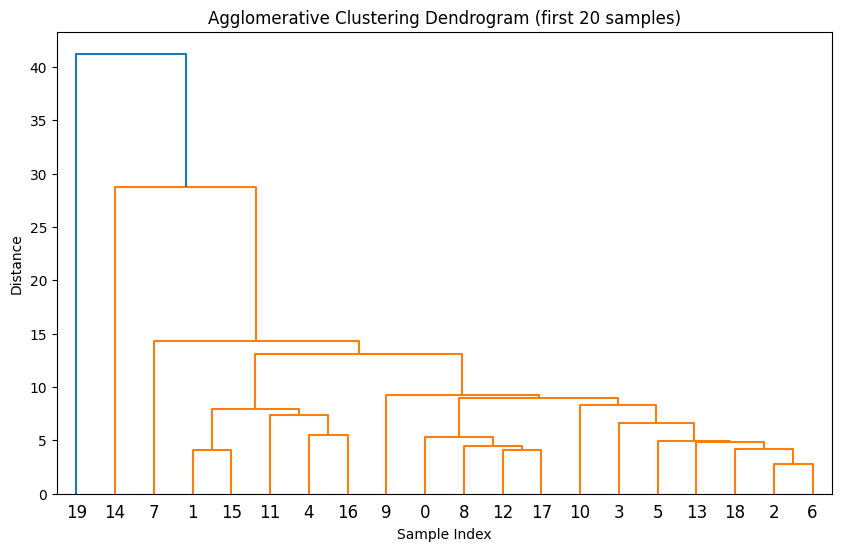

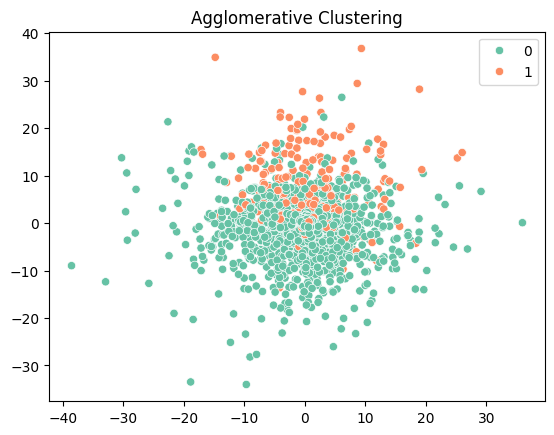

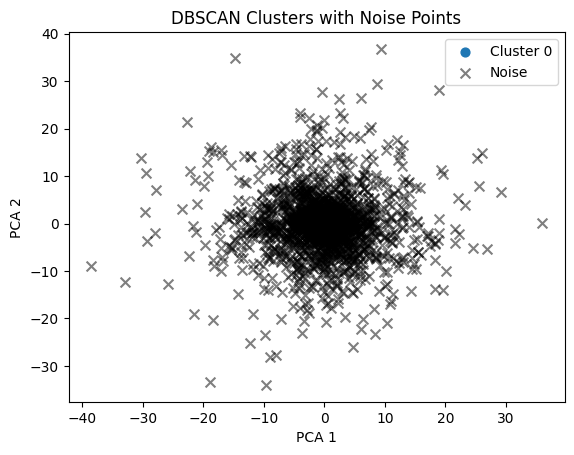

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_kmeans(X_2d, labels, model):
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='viridis', s=40)
    centers = model.cluster_centers_
    plt.scatter(centers[:,0], centers[:,1], c='red', s=200, marker='X')
    plt.title("KMeans Clusters and Centroids")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

def plot_gmm(X_2d, labels, model):
    plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='viridis', s=40)
    ax = plt.gca()
    for i in range(model.n_components):
        mean = model.means_[i,:2]
        cov = model.covariances_[i][:2,:2]
        eigenvals, eigenvecs = np.linalg.eigh(cov)
        order = eigenvals.argsort()[::-1]
        eigenvals, eigenvecs = eigenvals[order], eigenvecs[:, order]
        angle = np.degrees(np.arctan2(*eigenvecs[:,0][::-1]))
        width, height = 2 * np.sqrt(eigenvals)
        ellipse = Ellipse(mean, width, height, angle=angle, alpha=0.3, color='red')
        ax.add_patch(ellipse)
    plt.title("GMM Clusters with Gaussian Ellipses")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.show()

def plot_agglomerative_dendrogram(X, max_samples=20):
    # Take only the first max_samples rows for dendrogram
    X_subset = X[:max_samples]
    Z = linkage(X_subset, method='ward')
    plt.figure(figsize=(10, 6))
    dendrogram(Z, labels=np.arange(max_samples))
    plt.title(f"Agglomerative Clustering Dendrogram (first {max_samples} samples)")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()

def plot_dbscan(X_2d, labels):
    unique_labels = set(labels)
    colors = sns.color_palette('tab10', n_colors=len(unique_labels))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Noise
            col = (0, 0, 0, 0.5)  # grey/black semi-transparent
            marker = 'x'
            size = 50
        else:
            marker = 'o'
            size = 40
        class_member_mask = (labels == k)
        xy = X_2d[class_member_mask]
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker=marker, s=size, label=f'Cluster {k}' if k!=-1 else 'Noise')
    plt.title("DBSCAN Clusters with Noise Points")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.show()

# Example usage inside your loop, after fitting models and PCA transform:
for name, model in models.items():
    if name == "KMeans":
        labels = model.predict(X_train) if hasattr(model, 'predict') else model.fit_predict(X_train)
        plot_kmeans(X_train_vis, labels, model)
    elif name == "GMM":
        labels = model.predict(X_train)
        plot_gmm(X_train_vis, labels, model)
    elif name == "Agglomerative":
      plot_agglomerative_dendrogram(X_train, max_samples=20)  # plot dendrogram on first 20 samples
      labels = model.fit_predict(X_train)
      sns.scatterplot(x=X_train_vis[:,0], y=X_train_vis[:,1], hue=labels, palette='Set2')
      plt.title("Agglomerative Clustering")
      plt.show()
    elif name == "DBSCAN":
        labels = model.fit_predict(X_train)
        plot_dbscan(X_train_vis, labels)



🔍 Fine-tuning DBSCAN...

✅ Best DBSCAN Params: {'eps': np.float64(5.0), 'min_samples': 5} | Silhouette Score (Train): 0.4274

--- Tuned DBSCAN ---
Silhouette Train: 0.4274 | Test: 0.3927 => Borderline
F1 Train: 0.8488 | F1 Test: 0.8074
Confusion Matrix (Train):
[[6722  638]
 [  13 1827]]
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      7360
           1       0.74      0.99      0.85      1840

    accuracy                           0.93      9200
   macro avg       0.87      0.95      0.90      9200
weighted avg       0.95      0.93      0.93      9200

Confusion Matrix (Test):
[[1622  218]
 [   1  459]]
Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.88      0.94      1840
           1       0.68      1.00      0.81       460

    accuracy                           0.90      2300
   macro avg       0.84      0.94      0.87      230

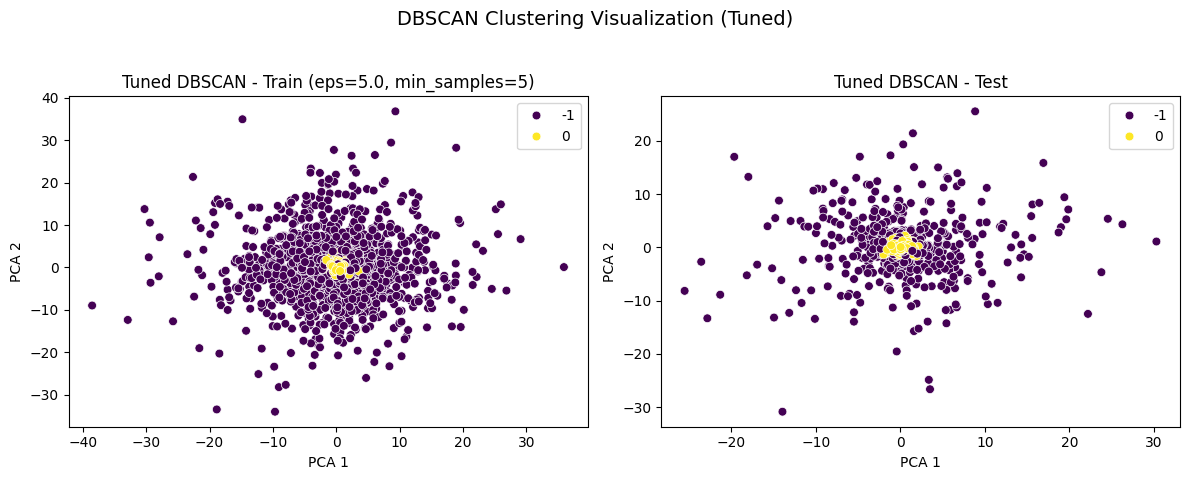

In [ ]:
# Grid search for DBSCAN
best_score = -1
best_params = {}
best_train_clusters = None
best_test_clusters = None

eps_values = np.arange(0.5, 5.1, 0.5)
min_samples_values = [3, 5, 7, 10]

print("\n🔍 Fine-tuning DBSCAN...")

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        try:
            train_clusters = dbscan.fit_predict(X_train)
            # Must have at least 2 clusters to compute silhouette
            if len(set(train_clusters)) < 2 or len(set(train_clusters)) == 1:
                continue
            sil_score = silhouette_score(X_train, train_clusters)
            if sil_score > best_score:
                best_score = sil_score
                best_params = {'eps': eps, 'min_samples': min_samples}
                best_train_clusters = train_clusters
                best_test_clusters = dbscan.fit_predict(X_test)
        except:
            continue

# Re-evaluate with best params
print(f"\n✅ Best DBSCAN Params: {best_params} | Silhouette Score (Train): {best_score:.4f}")

# Remap and score
best_dbscan = DBSCAN(**best_params)
train_clusters = best_dbscan.fit_predict(X_train)
test_clusters = best_dbscan.fit_predict(X_test)

train_labels = map_clusters_to_labels(train_clusters, y_train.values)
test_labels = map_clusters_to_labels(test_clusters, y_test.values)

f1_train = f1_score(y_train, train_labels)
f1_test = f1_score(y_test, test_labels)
sil_train = silhouette_score(X_train, train_clusters)
sil_test = silhouette_score(X_test, test_clusters)

# Determine new fit status
if sil_train >= 0.5 and sil_test >= 0.5 and abs(sil_train - sil_test) < 0.1:
    fit_status = "Good Fit"
elif sil_train >= 0.5 and sil_test < 0.3:
    fit_status = "Overfitting"
elif sil_train < 0.3 and sil_test < 0.3:
    fit_status = "Underfitting"
else:
    fit_status = "Borderline"

print(f"\n--- Tuned DBSCAN ---")
print(f"Silhouette Train: {sil_train:.4f} | Test: {sil_test:.4f} => {fit_status}")
print(f"F1 Train: {f1_train:.4f} | F1 Test: {f1_test:.4f}")
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, train_labels))
print("Classification Report (Train):")
print(classification_report(y_train, train_labels))
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, test_labels))
print("Classification Report (Test):")
print(classification_report(y_test, test_labels))


# Visualize tuned DBSCAN clusters
pca_vis = PCA(n_components=2, random_state=42)
X_train_vis = pca_vis.fit_transform(X_train)
X_test_vis = pca_vis.transform(X_test)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train_vis[:, 0], y=X_train_vis[:, 1], hue=train_clusters, palette='viridis', s=40)
plt.title(f"Tuned DBSCAN - Train (eps={best_params['eps']}, min_samples={best_params['min_samples']})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_test_vis[:, 0], y=X_test_vis[:, 1], hue=test_clusters, palette='viridis', s=40)
plt.title("Tuned DBSCAN - Test")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.suptitle("DBSCAN Clustering Visualization (Tuned)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


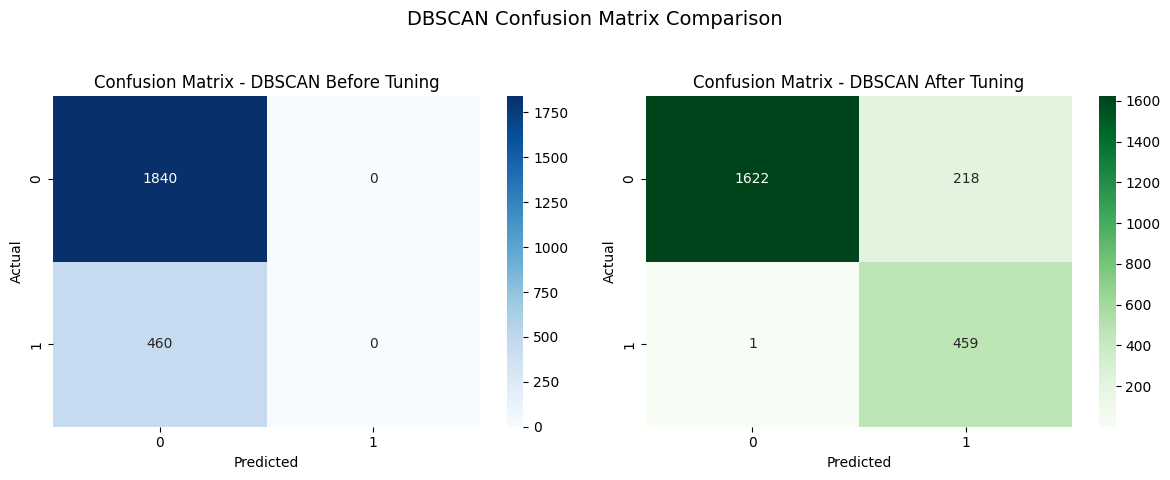

In [ ]:
# Reduce to 2D for visual comparison (This part is for plotting later if needed,
# the clustering itself uses the 40 components X_test)
# pca_vis = PCA(n_components=2, random_state=42)
# X_train_vis = pca_vis.fit_transform(X_train)
# X_test_vis = pca_vis.transform(X_test)

# Before tuning: Use original DBSCAN (eps=3, min_samples=5)
original_dbscan = DBSCAN(eps=3, min_samples=5)
# Fit on X_train, predict on X_test
original_train_clusters = original_dbscan.fit_predict(X_train)
original_test_clusters = original_dbscan.fit_predict(X_test) # Define original_test_clusters here

# After tuning: Use best DBSCAN (Assuming best_dbscan and best_test_clusters from previous cell are available)
# If not, re-run the previous cell or define them here as well:
tuned_dbscan = DBSCAN(**best_params) # <-- Uncomment this line
tuned_train_clusters = tuned_dbscan.fit_predict(X_train) # <-- Uncomment this line
tuned_test_clusters = tuned_dbscan.fit_predict(X_test) # <-- Uncomment this line


original_test_labels = map_clusters_to_labels(original_test_clusters, y_test.values)
tuned_test_labels = map_clusters_to_labels(tuned_test_clusters, y_test.values)

# Confusion Matrices
cm_before = confusion_matrix(y_test, original_test_labels)
cm_after = confusion_matrix(y_test, tuned_test_labels)

# 📊 Plot Side-by-Side Confusion Matrices
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - DBSCAN Before Tuning")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - DBSCAN After Tuning")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.suptitle("DBSCAN Confusion Matrix Comparison", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

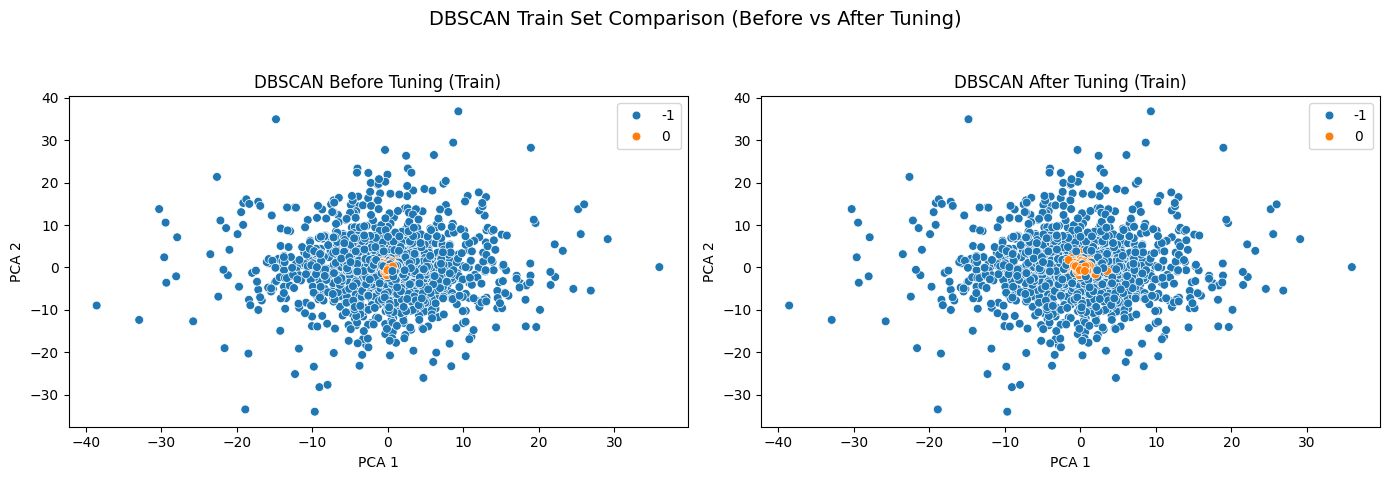

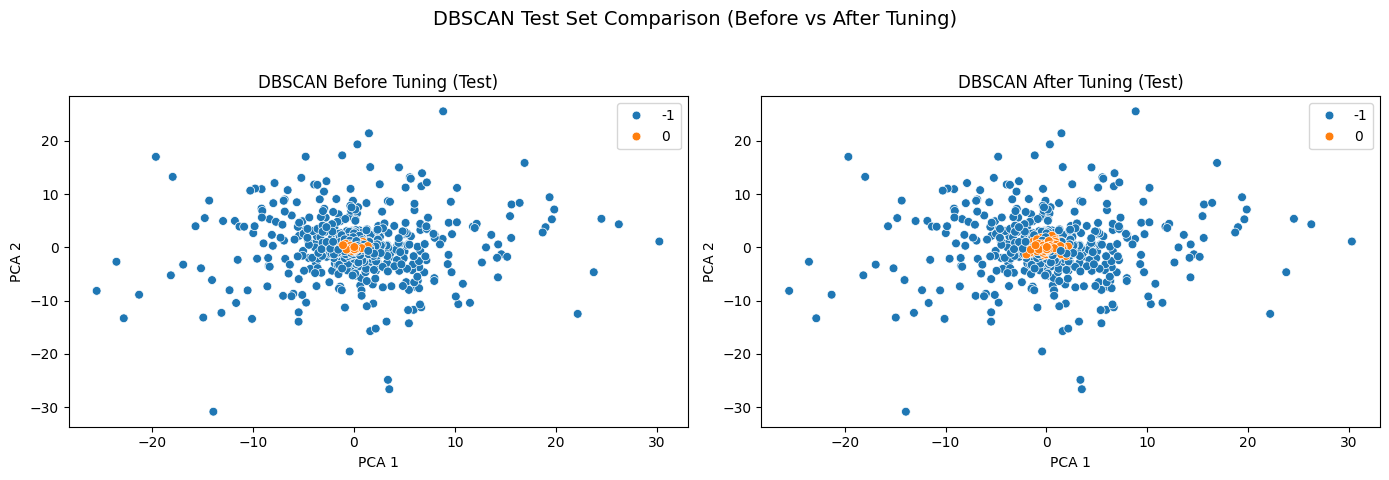

In [ ]:
# Reduce to 2D for visual comparison
pca_vis = PCA(n_components=2, random_state=42)
X_train_vis = pca_vis.fit_transform(X_train)
X_test_vis = pca_vis.transform(X_test)

# Before tuning: Use original DBSCAN (eps=3, min_samples=5)
original_dbscan = DBSCAN(eps=3, min_samples=5)
original_train_clusters = original_dbscan.fit_predict(X_train)
original_test_clusters = original_dbscan.fit_predict(X_test)

# After tuning: Use best DBSCAN
tuned_dbscan = DBSCAN(**best_params)
tuned_train_clusters = tuned_dbscan.fit_predict(X_train)
tuned_test_clusters = tuned_dbscan.fit_predict(X_test)

# Plot Train Comparison
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_train_vis[:, 0], y=X_train_vis[:, 1], hue=original_train_clusters, palette='tab10', s=40)
plt.title("DBSCAN Before Tuning (Train)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_train_vis[:, 0], y=X_train_vis[:, 1], hue=tuned_train_clusters, palette='tab10', s=40)
plt.title("DBSCAN After Tuning (Train)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.suptitle("DBSCAN Train Set Comparison (Before vs After Tuning)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot Test Comparison
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=X_test_vis[:, 0], y=X_test_vis[:, 1], hue=original_test_clusters, palette='tab10', s=40)
plt.title("DBSCAN Before Tuning (Test)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.subplot(1, 2, 2)
sns.scatterplot(x=X_test_vis[:, 0], y=X_test_vis[:, 1], hue=tuned_test_clusters, palette='tab10', s=40)
plt.title("DBSCAN After Tuning (Test)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.suptitle("DBSCAN Test Set Comparison (Before vs After Tuning)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# ***Frontend***

In [ ]:
# === STEP 0: Install dependencies (if needed) ===
!pip install -q imbalanced-learn

# === STEP 1: Imports and Data Load ===
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib
from google.colab import files

# === STEP 2: Load and preprocess data ===
data = pd.read_csv('cleaned_seizure_data.csv')  # Make sure this file is uploaded to Colab
data['y_binary'] = (data['y'] == 1).astype(int)
X = data.drop(columns=['y', 'y_binary'])
y = data['y_binary']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# === STEP 3: Train RandomForest with tuning ===
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=5,
    cv=3, scoring='f1', n_jobs=-1, random_state=42, verbose=1
)
random_search.fit(X_train_sm, y_train_sm)

# === STEP 4: Save model and scaler ===
joblib.dump(random_search.best_estimator_, 'seizure_rf_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

# === STEP 5: Create seizure_app.py file ===
app_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from streamlit_extras.metric_cards import style_metric_cards
from streamlit_extras.stylable_container import stylable_container
from matplotlib.colors import LinearSegmentedColormap
import random

# Configure page
st.set_page_config(
    page_title="NeuroVision | Seizure Detection",
    page_icon="🧠",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS
st.markdown(f"""
<style>
    @import url('https://fonts.googleapis.com/css2?family=Poppins:wght@300;400;600;700&display=swap');

    * {{
        font-family: 'Poppins', sans-serif;
    }}

    .main {{
        background-color: #f8fafc;
    }}

    /* Team Header with Glow Effect */
    .team-name {{
        font-size: 3.5rem !important;
        font-weight: 700;
        text-align: center;
        margin: 0.5rem 0;
        background: linear-gradient(90deg, #4f46e5, #8b5cf6);
        -webkit-background-clip: text;
        background-clip: text;
        color: transparent;
        text-shadow: 0 0 10px rgba(139, 92, 246, 0.3);
        letter-spacing: 1px;
    }}

    /* Soft Cards */
    .custom-card {{
        background: white;
        border-radius: 12px;
        padding: 1.5rem;
        box-shadow: 0 4px 20px rgba(0,0,0,0.05);
        border-left: 4px solid #8b5cf6;
        margin-bottom: 1.5rem;
    }}

    /* Prediction Cards */
    .seizure-card {{
        background: linear-gradient(135deg, #fef2f2, #fff);
        border: 1px solid #fecaca;
        border-left: 4px solid #ef4444;
    }}

    .normal-card {{
        background: linear-gradient(135deg, #f0fdf4, #fff);
        border: 1px solid #bbf7d0;
        border-left: 4px solid #22c55e;
    }}

    /* Beautiful Button */
    .stButton>button {{
        background: linear-gradient(90deg, #4f46e5, #8b5cf6);
        color: white;
        border: none;
        border-radius: 8px;
        padding: 0.75rem 1.5rem;
        font-weight: 600;
        transition: all 0.3s;
    }}

    .stButton>button:hover {{
        transform: translateY(-2px);
        box-shadow: 0 4px 12px rgba(79, 70, 229, 0.3);
    }}

    /* Risk Meter */
    .risk-meter {{
        height: 12px;
        border-radius: 6px;
        background: linear-gradient(90deg, #22c55e, #facc15, #ef4444);
        margin: 1rem 0;
    }}

    /* Quote Box */
    .quote-box {{
        background: linear-gradient(135deg, #f8fafc, #e2e8f0);
        border-radius: 12px;
        padding: 1.5rem;
        border-left: 4px solid #8b5cf6;
        font-style: italic;
        margin: 1rem 0;
    }}
</style>
""", unsafe_allow_html=True)

# Inspirational Quotes
QUOTES = [
    "Every great advance in medicine has begun with a bold idea.",
    "Technology is nothing. What's important is that you have faith in people.",
    "The art of medicine consists of amusing the patient while nature cures the disease.",
    "In the middle of difficulty lies opportunity.",
    "The best way to predict the future is to invent it."
]

# Load model and scaler
@st.cache_resource
def load_model():
    model = joblib.load('seizure_rf_model.joblib')
    scaler = joblib.load('scaler.joblib')
    return model, scaler

model, scaler = load_model()

# Initialize session state
if 'input_data' not in st.session_state:
    st.session_state.input_data = pd.DataFrame(
        np.zeros((1, 178)),
        columns=[f'X{i}' for i in range(1, 179)]
    )

# Sidebar with Quotes and Info
with st.sidebar:
    st.markdown("""
    <div style='text-align:center; margin-bottom:2rem;'>
        <h2 style='color: #4f46e5;'>NeuroVision</h2>
        <p style='color: #64748b;'>EEG Analysis Suite</p>
    </div>
    """, unsafe_allow_html=True)

    with stylable_container(
        key="quote_container",
        css_styles="""
            {
                background: white;
                border-radius: 12px;
                padding: 1.5rem;
                box-shadow: 0 4px 12px rgba(0,0,0,0.05);
                margin-bottom: 1.5rem;
            }
        """
    ):
        st.markdown("### 🌟 Today's Inspiration")
        st.markdown(f'<div class="quote-box">"{random.choice(QUOTES)}"</div>', unsafe_allow_html=True)

    st.markdown("""
    <div style='margin-top:2rem;'>
        <h4>🧠 About This App</h4>
        <p style='font-size:0.9rem; color:#64748b;'>
        Advanced machine learning system for detecting seizure activity in EEG signals.
        Developed with care by Team CurioSapiens.
        </p>
    </div>
    """, unsafe_allow_html=True)

# Main Content
st.markdown('<p class="team-name">CurioSapiens</p>', unsafe_allow_html=True)
st.markdown('<p style="text-align:center; color:#64748b; margin-bottom:2rem;">Medical Innovation Team | Paarth Gupta | Madan M | Kamma Srikar | B Naga Krishna Manohar</p>', unsafe_allow_html=True)

# Three Main Sections
tab1, tab2, tab3 = st.tabs(["🧠 Patient Analysis", "📊 Visualization", "⚙️ Settings"])

with tab1:
    # Feature Input Card
    with stylable_container(
        key="input_card",
        css_styles="""
            {
                background: white;
                border-radius: 12px;
                padding: 1.5rem;
                box-shadow: 0 4px 20px rgba(0,0,0,0.05);
                margin-bottom: 1.5rem;
            }
        """
    ):
        st.markdown("### 📋 EEG Feature Input")
        st.markdown("Enter values or generate sample data")

        col1, col2 = st.columns(2)
        with col1:
            if st.button("🎲 Generate Sample Data", use_container_width=True):
                st.session_state.input_data = pd.DataFrame(
                    np.random.normal(0, 1, (1, 178)),
                    columns=[f'X{i}' for i in range(1, 179)]
                st.toast("Sample data generated!", icon="🎲")

        with col2:
            if st.button("🧹 Clear Data", use_container_width=True):
                st.session_state.input_data = pd.DataFrame(
                    np.zeros((1, 178)),
                    columns=[f'X{i}' for i in range(1, 179)]
                )
                st.toast("Data cleared!", icon="🧹")

        st.data_editor(
            st.session_state.input_data,
            height=300,
            use_container_width=True
        )

    # Analysis Card
    if st.button("🔍 Analyze EEG Signals", type="primary", use_container_width=True):
        try:
            # Prediction logic
            input_values = st.session_state.input_data.astype(float).values
            scaled_input = scaler.transform(input_values)
            prediction = model.predict(scaled_input)
            proba = model.predict_proba(scaled_input)

            # Results Card
            if prediction[0] == 1:
                with stylable_container(
                    key="seizure_result",
                    css_styles="""
                        {
                            background: white;
                            border-radius: 12px;
                            padding: 1.5rem;
                            box-shadow: 0 4px 20px rgba(0,0,0,0.05);
                            margin: 1.5rem 0;
                        }
                    """
                ):
                    st.markdown("""
                    <div style='text-align:center;'>
                        <h1 style='color:#ef4444;'>⚠️ Seizure Detected</h1>
                        <p style='font-size:1.1rem; color:#64748b;'>
                        Immediate medical review recommended
                        </p>
                    </div>
                    """, unsafe_allow_html=True)
            else:
                with stylable_container(
                    key="normal_result",
                    css_styles="""
                        {
                            background: white;
                            border-radius: 12px;
                            padding: 1.5rem;
                            box-shadow: 0 4px 20px rgba(0,0,0,0.05);
                            margin: 1.5rem 0;
                        }
                    """
                ):
                    st.markdown("""
                    <div style='text-align:center;'>
                        <h1 style='color:#22c55e;'>😊 Normal Activity</h1>
                        <p style='font-size:1.1rem; color:#64748b;'>
                        No signs of seizure detected
                        </p>
                    </div>
                    """, unsafe_allow_html=True)

            # Risk Meter
            st.markdown("### 📏 Seizure Risk Assessment")
            risk = proba[0][1] * 100
            st.markdown(f"""
            <div style='margin:1rem 0;'>
                <div style='display:flex; justify-content:space-between;'>
                    <span style='color:#22c55e;'>Low</span>
                    <span style='color:#facc15;'>Medium</span>
                    <span style='color:#ef4444;'>High</span>
                </div>
                <div class="risk-meter">
                    <div style='width:{risk}%; height:12px; background-color:rgba(255,255,255,0.3); border-radius:6px;'></div>
                </div>
                <div style='text-align:center; margin-top:0.5rem;'>
                    <span style='font-weight:600;'>Current Risk: {risk:.1f}%</span>
                </div>
            </div>
            """, unsafe_allow_html=True)

            # Metrics
            cols = st.columns(2)
            with cols[0]:
                with stylable_container(
                    key="normal_metric",
                    css_styles="""
                        {
                            background: white;
                            border-radius: 12px;
                            padding: 1rem;
                            box-shadow: 0 4px 12px rgba(0,0,0,0.05);
                        }
                    """
                ):
                    st.metric(
                        label="Normal Probability",
                        value=f"{proba[0][0]*100:.1f}%",
                        delta_color="off"
                    )

            with cols[1]:
                with stylable_container(
                    key="seizure_metric",
                    css_styles="""
                        {
                            background: white;
                            border-radius: 12px;
                            padding: 1rem;
                            box-shadow: 0 4px 12px rgba(0,0,0,0.05);
                        }
                    """
                ):
                    st.metric(
                        label="Seizure Probability",
                        value=f"{proba[0][1]*100:.1f}%",
                        delta_color="off"
                    )

            style_metric_cards()

        except Exception as e:
            st.error(f"Analysis error: {str(e)}")

with tab2:
    # Visualization Tab
    with stylable_container(
        key="viz_card",
        css_styles="""
            {
                background: white;
                border-radius: 12px;
                padding: 1.5rem;
                box-shadow: 0 4px 20px rgba(0,0,0,0.05);
                margin-bottom: 1.5rem;
            }
        """
    ):
        st.markdown("### 📈 EEG Signal Features")

        if not st.session_state.input_data.empty:
            # Create plot
            fig, ax = plt.subplots(figsize=(12, 4))
            ax.plot(st.session_state.input_data.values.flatten(), color='#8b5cf6', alpha=0.7)
            ax.set_title('EEG Signal Pattern', pad=20)
            ax.set_xlabel('Feature Index')
            ax.set_ylabel('Value')
            ax.grid(True, linestyle='--', alpha=0.3)
            st.pyplot(fig)

            # Feature distribution
            st.markdown("### 🔍 Feature Distribution")
            fig2, ax2 = plt.subplots(figsize=(12, 4))
            ax2.hist(st.session_state.input_data.values.flatten(), bins=30, color='#8b5cf6', alpha=0.7)
            ax2.set_title('Feature Value Distribution', pad=20)
            ax2.grid(True, linestyle='--', alpha=0.3)
            st.pyplot(fig2)
        else:
            st.warning("No data available. Please generate or input data in the Patient Analysis tab.")

with tab3:
    # Settings Tab
    with stylable_container(
        key="settings_card",
        css_styles="""
            {
                background: white;
                border-radius: 12px;
                padding: 1.5rem;
                box-shadow: 0 4px 20px rgba(0,0,0,0.05);
                margin-bottom: 1.5rem;
            }
        """
    ):
        st.markdown("### ⚙️ Application Settings")

        st.selectbox("Theme", ["Light", "Dark"], index=0)
        st.slider("Chart Detail Level", 1, 5, 3)
        st.checkbox("Enable Notifications", value=True)
        st.checkbox("Show Tutorial", value=False)

        if st.button("Save Settings", type="primary"):
            st.toast("Settings saved!", icon="✅")

# Footer
st.markdown("---")
st.markdown("""
<div style='text-align:center; color:#64748b; font-size:0.9rem; margin-top:2rem;'>
    <p>Developed with ❤️ by Team CurioSapiens | NeuroVision EEG Analysis System</p>
    <p>© 2023 All Rights Reserved</p>
</div>
""", unsafe_allow_html=True)'''

with open("seizure_app.py", "w") as f:
    f.write(app_code)

print("✅ All files created successfully!")
from google.colab import files
files.download("seizure_app.py")
#files.download("scaler.joblib")
#files.download("seizure_rf_model.joblib")
